In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet


In [1]:
import torch
torch.set_float32_matmul_precision('high')

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from os.path import join

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [3]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_simple_norm_parquet'

CKPT_PATHS = [
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_7/checkpoints/val_f1_macro_epoch=46_val_f1_macro=0.751.ckpt',
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_8/checkpoints/val_f1_macro_epoch=45_val_f1_macro=0.747.ckpt',
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_9/checkpoints/val_f1_macro_epoch=48_val_f1_macro=0.748.ckpt',
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_10/checkpoints/val_f1_macro_epoch=53_val_f1_macro=0.751.ckpt',
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_11/checkpoints/val_f1_macro_epoch=37_val_f1_macro=0.750.ckpt',
    '/mnt/dssfs02/tb_logs/juwles/tabnet/default/version_12/checkpoints/val_f1_macro_epoch=43_val_f1_macro=0.751.ckpt',
]

In [4]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# Get ensembl predictions

In [5]:
import gc


def get_ensemble_preds(ckpts):
    estim = EstimatorCellTypeClassifier(DATA_PATH)
    estim.init_datamodule(batch_size=2048)
    estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

    probas = []

    for ckpt in ckpts:
        estim.model = TabnetClassifier.load_from_checkpoint(ckpt, **estim.get_fixed_model_params('tabnet'))
        probas.append(estim.predict(estim.datamodule.test_dataloader()))
        gc.collect()

    return np.stack(probas, axis=-1).mean(axis=-1), np.stack(probas, axis=-1)


In [6]:
probas, probas_per_model = get_ensemble_preds(CKPT_PATHS)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [03:02<00:00,  3.75it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [02:43<00:00,  4.18it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [02:42<00:00,  4.23it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [02:37<00:00,  4.35it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [02:41<00:00,  4.24it/s]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 686/686 [02:44<00:00,  4.17it/s]


# Evaluate performance

In [7]:
from utils import correct_labels

In [8]:
y_pred = np.argmax(probas, axis=1)
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

### Overall performance

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

In [10]:
clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
accuracy,0.891116,0.891116,0.891116,8.911165e-01
macro avg,0.773247,0.823277,0.782093,1.403904e+06
weighted avg,0.904339,0.891116,0.892320,1.403904e+06


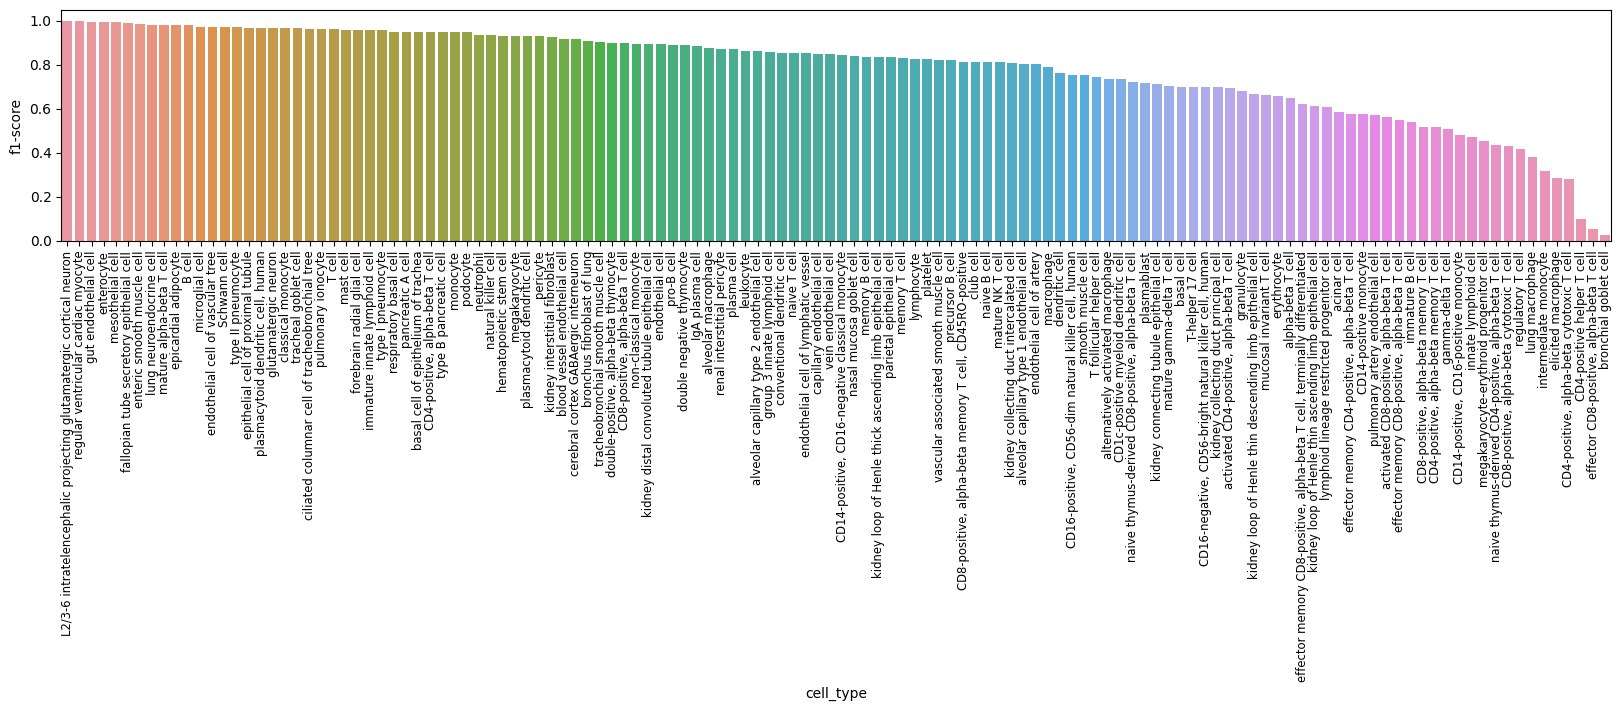

In [11]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
)
ax.tick_params(axis='x', labelrotation=90)
ax.xaxis.set_tick_params(labelsize='small');

### Uncertainty

#### Mathematical evaluation

In [55]:
thresholds = np.linspace(0.05, 0.95, 10)
n_ensembles = [1, 2, 3, 4, 5, 6]
f1_scores = np.zeros((len(n_ensembles), len(thresholds)))
accuracys = np.zeros((len(n_ensembles), len(thresholds)))

for i, n in enumerate(n_ensembles):
    p = probas_per_model[..., :n].mean(axis=-1)
    p_max = p.max(axis=-1)
    for j, threshold in enumerate(thresholds):
        p_bigger_threshold = np.where(p_max >= threshold)[0]
        report = pd.DataFrame(classification_report(y_true[p_bigger_threshold], y_pred_corr[p_bigger_threshold], output_dict=True)).T
        f1_scores[i, j] = report.loc['macro avg', 'f1-score']
        accuracys[i, j] = report.loc['accuracy', 'f1-score']


In [57]:
plt.rcParams['figure.figsize'] = (5, 4)


data = pd.DataFrame({
    'f1-score on examples p >= threshold': f1_scores.flatten(),
    'accuracy on examples p >= threshold': accuracys.flatten(),
    'threshold': np.tile(thresholds, len(n_ensembles)),
    '# models': np.repeat(n_ensembles, len(thresholds))
})

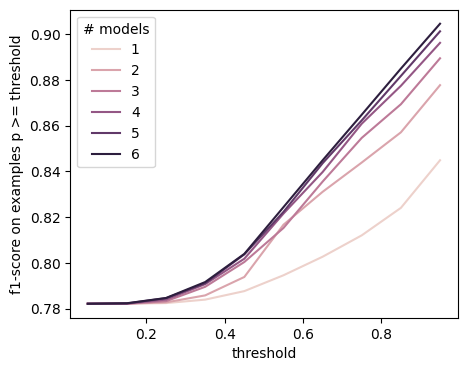

In [59]:
sns.lineplot(
    x='threshold',
    y='f1-score on examples p >= threshold',
    hue='# models',
    data=data
);

#### UMAP visualization

In [12]:
import anndata
import scanpy as sc

from scipy.stats import entropy

In [13]:
adata = anndata.AnnData(
    X=np.load(join(DATA_PATH, 'pca/x_pca_test_50.npy')), 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten(),
        'uncertainty': 1. - probas.max(axis=1),
        'uncertainty_entropy': entropy(probas, axis=1) / np.log(probas.shape[1])
    })
)
adata.obs['wrong_prediction'] = (adata.obs.y_true != adata.obs.y_pred).astype(str).astype('category')


/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [14]:
sc.pp.subsample(adata, n_obs=200_000)
sc.pp.neighbors(adata, use_rep='X')
sc.tl.tsne(adata, use_rep='X')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


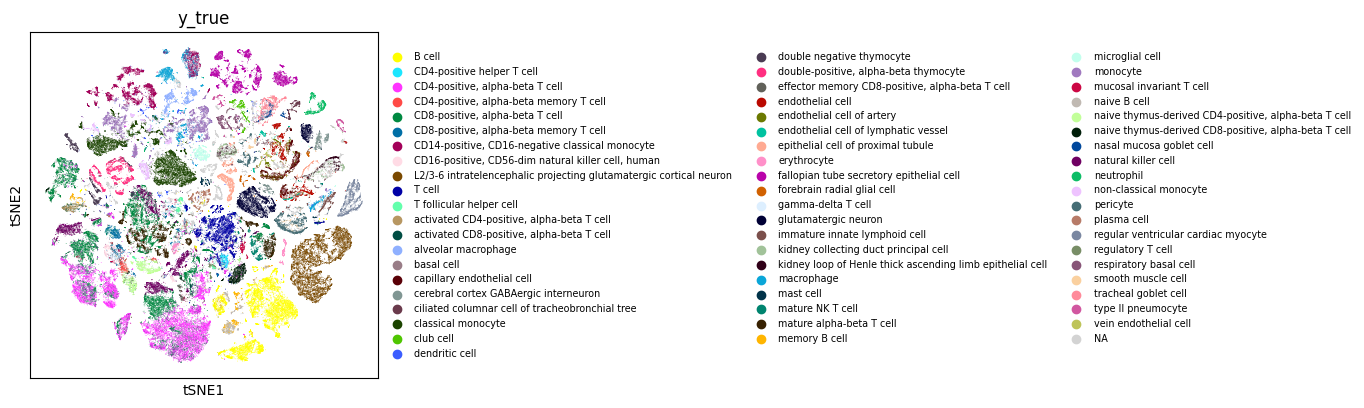

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


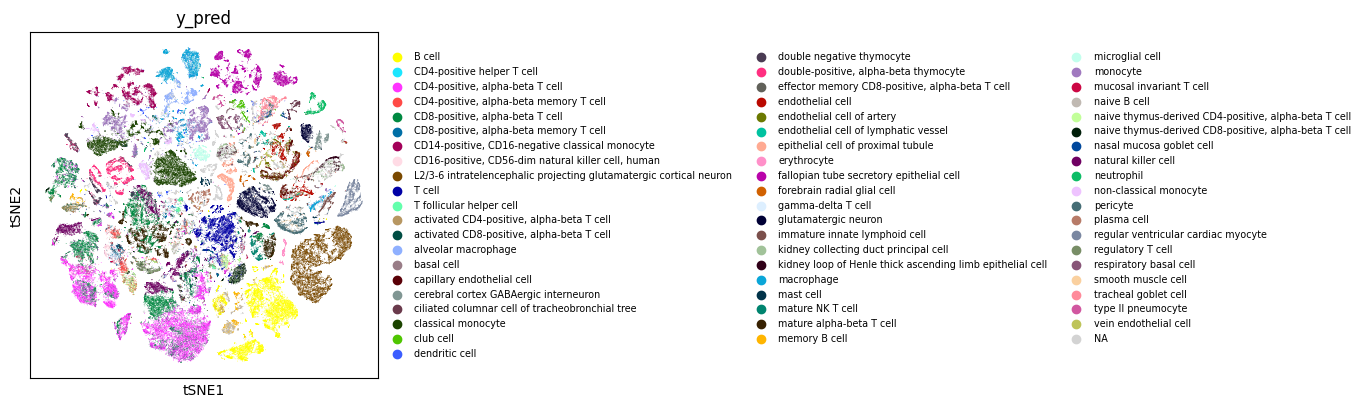

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


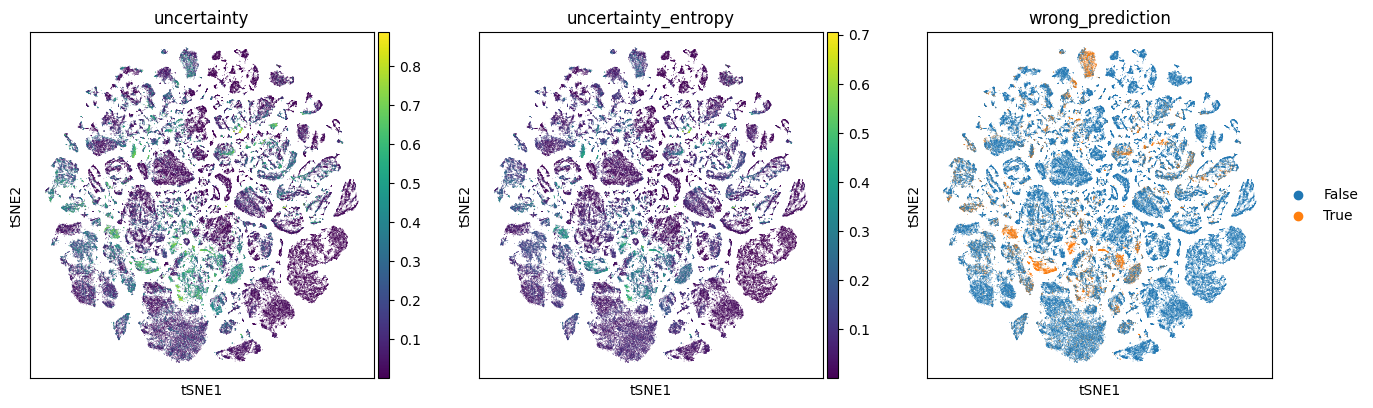

In [15]:
plt.rcParams['figure.figsize'] = (4.5, 4.5)

cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq[cell_freq > 500].index.tolist()
adata_plot = adata.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot))
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot))

sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_plot, color='y_pred', legend_fontsize='x-small', ncols=1)
sc.pl.tsne(adata_plot, color=['uncertainty', 'uncertainty_entropy', 'wrong_prediction'])